In [ ]:
cd /content/drive/MyDrive/mit_transcripts

/content/drive/MyDrive/mit_transcripts


In [ ]:
cd transcriptions/

[Errno 2] No such file or directory: 'transcriptions/'
/content/drive/MyDrive/mit_transcripts


In [ ]:
import pandas as pd
import numpy as np
import nltk
import random
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
mit_df = pd.read_csv('final_min_max_transcripts.csv')
mit_df

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,answers
0,p1,AGGR,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826,Im pretty good. ok uhm so have you looked a...
1,p3,AGGR,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691,Good. You? Yeah sorry I was- think I was la...
2,p4,AGGR,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246,Pretty good. Uhh so I'm a junior uhh studyin...
3,p5,AGGR,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970,Myself um I'm a junior majoring in computer...
4,p6,AGGR,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672,I’m doing good. How are you?Thank you. Well ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,pp83,AGGR,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047,Um pretty good pretty good. Getting busy wi...
134,pp84,AGGR,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313,Good thank you how are you? Alright well ...
135,pp85,AGGR,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612,Okay well I'm a junior here at MIT. Umm I'm...
136,pp86,AGGR,0.468334,0.436874,0.332273,0.650355,0.623955,0.724643,0.556480,0.618331,0.556723,0.482876,0.440450,0.694712,0.395540,0.637983,0.791330,0.349544,0.645462,0.646594,0.489470,In my technical background um. Been a junior...


In [ ]:
value_df = mit_df.drop(['Participant', 'Worker', 'answers'], axis=1)
value_df

,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
0,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826
1,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691
2,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246
3,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970
4,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047
134,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313
135,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612
136,0.468334,0.436874,0.332273,0.650355,0.623955,0.724643,0.556480,0.618331,0.556723,0.482876,0.440450,0.694712,0.395540,0.637983,0.791330,0.349544,0.645462,0.646594,0.489470


In [ ]:
corrMatrix = value_df.corr()

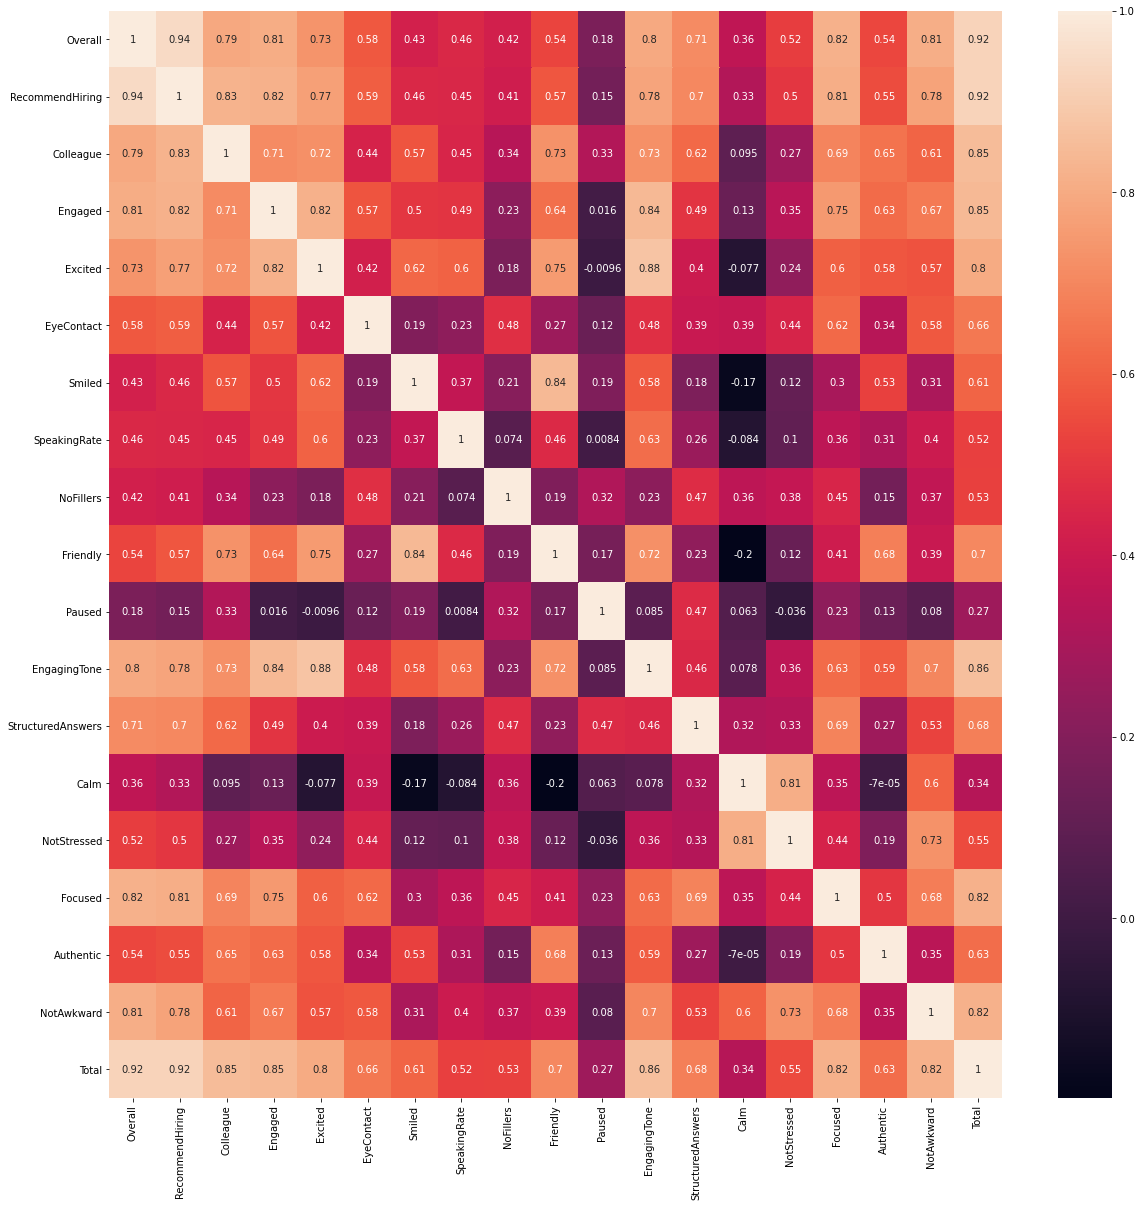

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
mit_df['RecommendHiringCat'] = np.where( mit_df['RecommendHiring'] > 0.5, 1, 0)
value_df['RecommendHiringCat'] = np.where( value_df['RecommendHiring'] > 0.5, 1, 0)
mit_df

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,answers,RecommendHiringCat
0,p1,AGGR,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826,Im pretty good. ok uhm so have you looked a...,1
1,p3,AGGR,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691,Good. You? Yeah sorry I was- think I was la...,0
2,p4,AGGR,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246,Pretty good. Uhh so I'm a junior uhh studyin...,0
3,p5,AGGR,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970,Myself um I'm a junior majoring in computer...,1
4,p6,AGGR,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672,I’m doing good. How are you?Thank you. Well ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,pp83,AGGR,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047,Um pretty good pretty good. Getting busy wi...,1
134,pp84,AGGR,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313,Good thank you how are you? Alright well ...,1
135,pp85,AGGR,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612,Okay well I'm a junior here at MIT. Umm I'm...,1
136,pp86,AGGR,0.468334,0.436874,0.332273,0.650355,0.623955,0.724643,0.556480,0.618331,0.556723,0.482876,0.440450,0.694712,0.395540,0.637983,0.791330,0.349544,0.645462,0.646594,0.489470,In my technical background um. Been a junior...,0


## Building DT's

In [ ]:
cont_train_labels = value_df['RecommendHiring'].values[:100]
cont_test_labels = value_df['RecommendHiring'].values[100:]
cat_train_labels = value_df['RecommendHiringCat'].values[:100]
cat_test_labels = value_df['RecommendHiringCat'].values[100:]
value_df = value_df.drop(['RecommendHiring', 'RecommendHiringCat', 'Overall', 'Total'], axis=1)
values = value_df.values
training_values = values[:100]
test_values = values[100:]

In [ ]:
value_df.columns

# ['Co', 'En', 'Ex', 'EC', 'S', 'SR', 'NF', 'Fr', 'P', 'ET', 'SA', 'Ca', 'NS', 'Fo', 'A', 'NA']

Index(['Colleague', 'Engaged', 'Excited', 'EyeContact', 'Smiled',
       'SpeakingRate', 'NoFillers', 'Friendly', 'Paused', 'EngagingTone',
       'StructuredAnswers', 'Calm', 'NotStressed', 'Focused', 'Authentic',
       'NotAwkward'],
      dtype='object')

In [ ]:
final_regr = DecisionTreeRegressor(max_depth=3)
final_regr.fit(training_values, cont_train_labels)

training_preds = final_regr.predict(training_values)
test_preds = final_regr.predict(test_values)

training_score = 1 - mean_absolute_error(cont_train_labels, training_preds)
test_score = 1 - mean_absolute_error(cont_test_labels, test_preds)

print(training_score)
print(test_score)

0.9427710030892051
0.8943357610053446


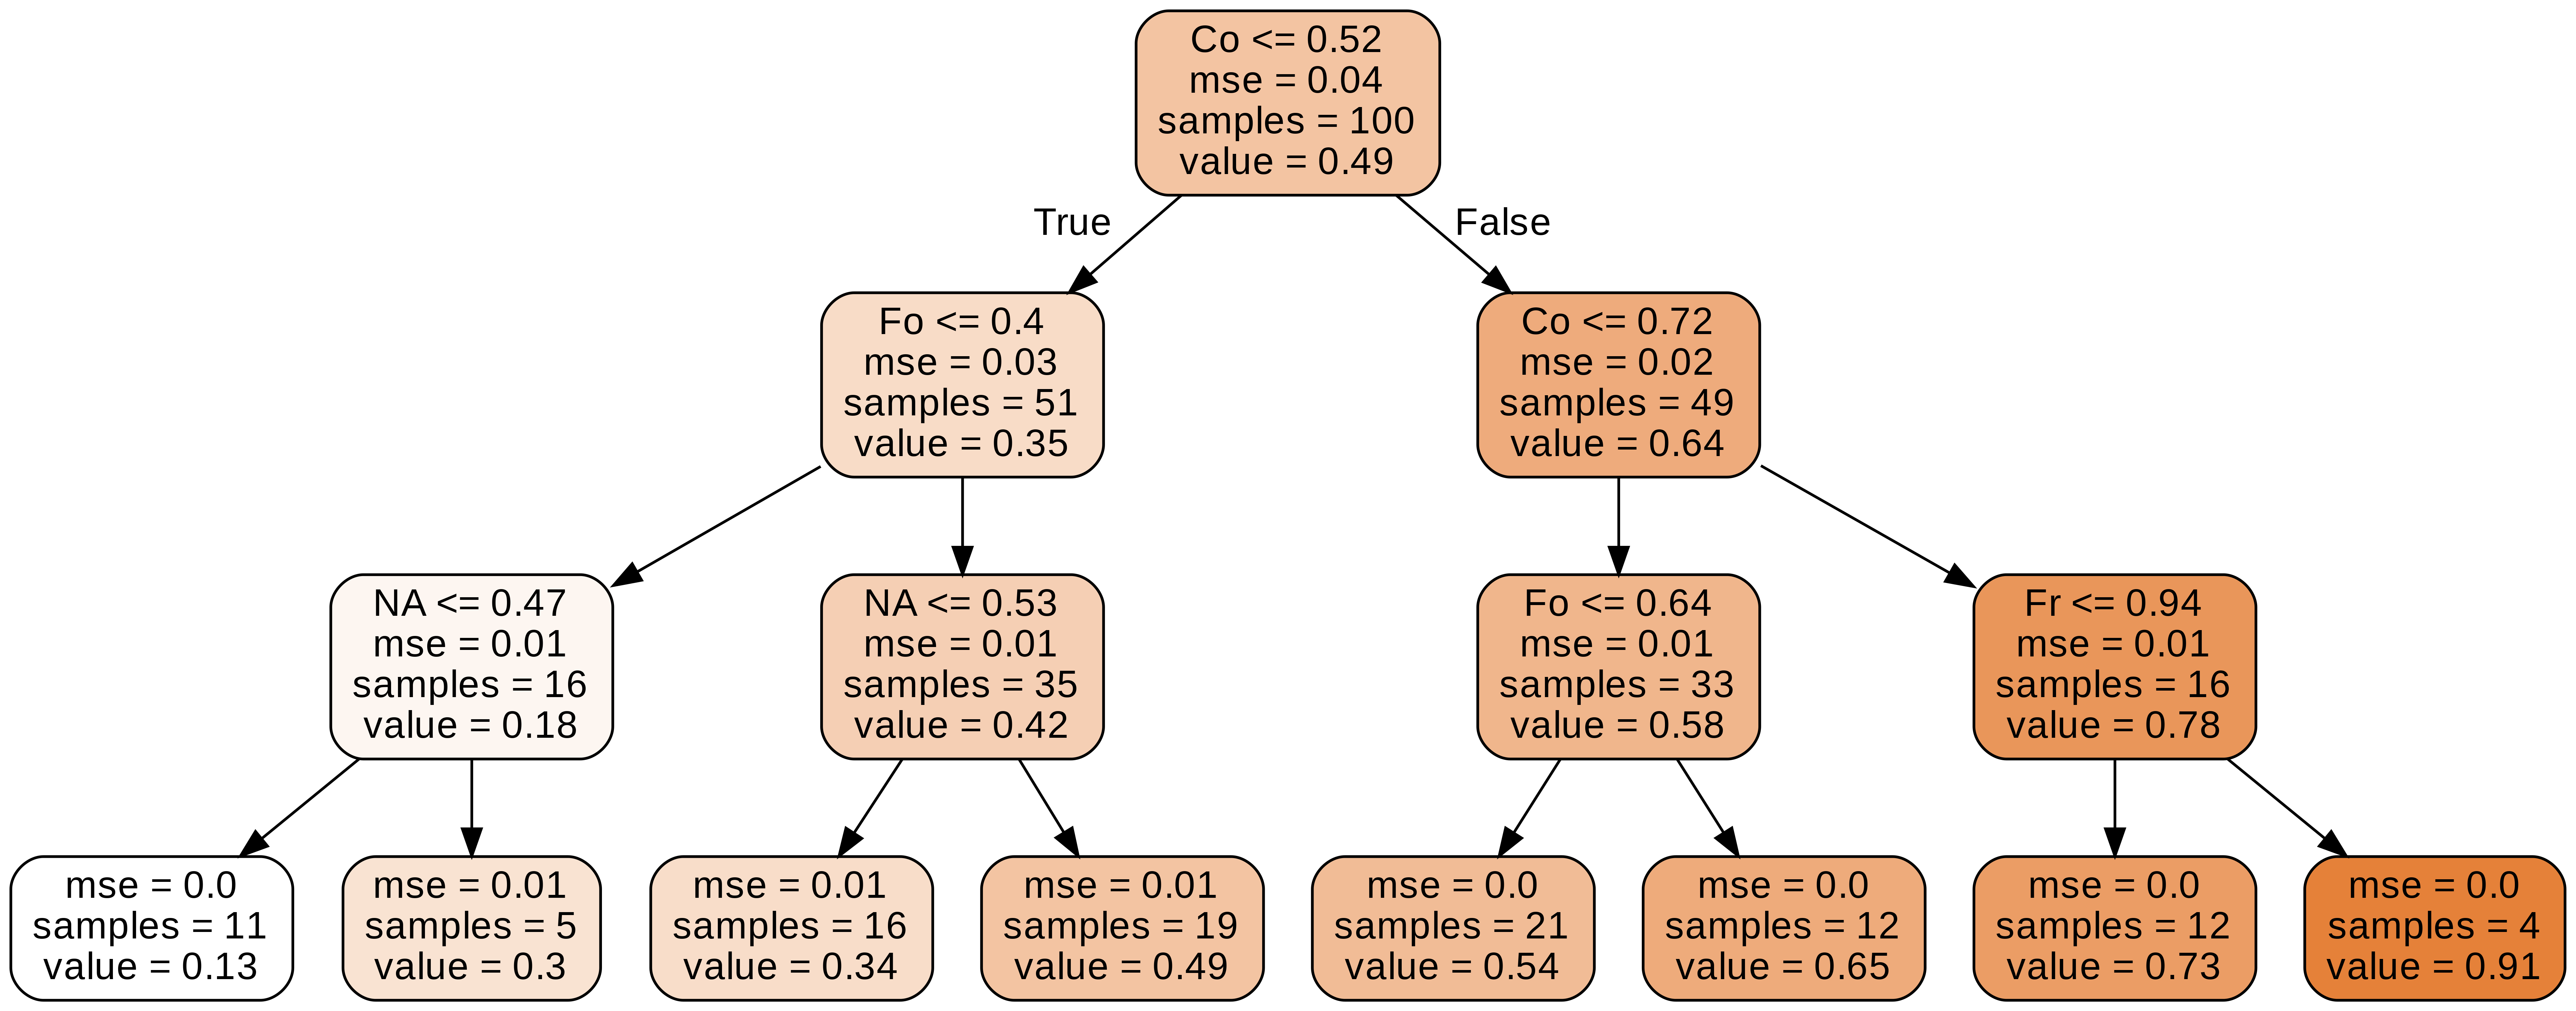

In [ ]:
from sklearn.tree import export_graphviz

feature_names = ['Co', 'En', 'Ex', 'EC', 'S', 'SR', 'NF', 'Fr', 'P', 'ET', 'SA', 'Ca', 'NS', 'Fo', 'A', 'NA']
# Export as dot file
export_graphviz(final_regr, out_file='tree-mit.dot', 
                feature_names = feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree-mit.dot', '-o', 'tree-mit.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree-mit.png')

In [ ]:
final_regr = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=6)
final_regr.fit(training_values, cat_train_labels)

training_preds = final_regr.predict(training_values)
test_preds = final_regr.predict(test_values)

training_score = 1 - mean_absolute_error(cat_train_labels, training_preds)
test_score = 1 - mean_absolute_error(cat_test_labels, test_preds)

print(training_score)
print(test_score)

0.95
0.9210526315789473


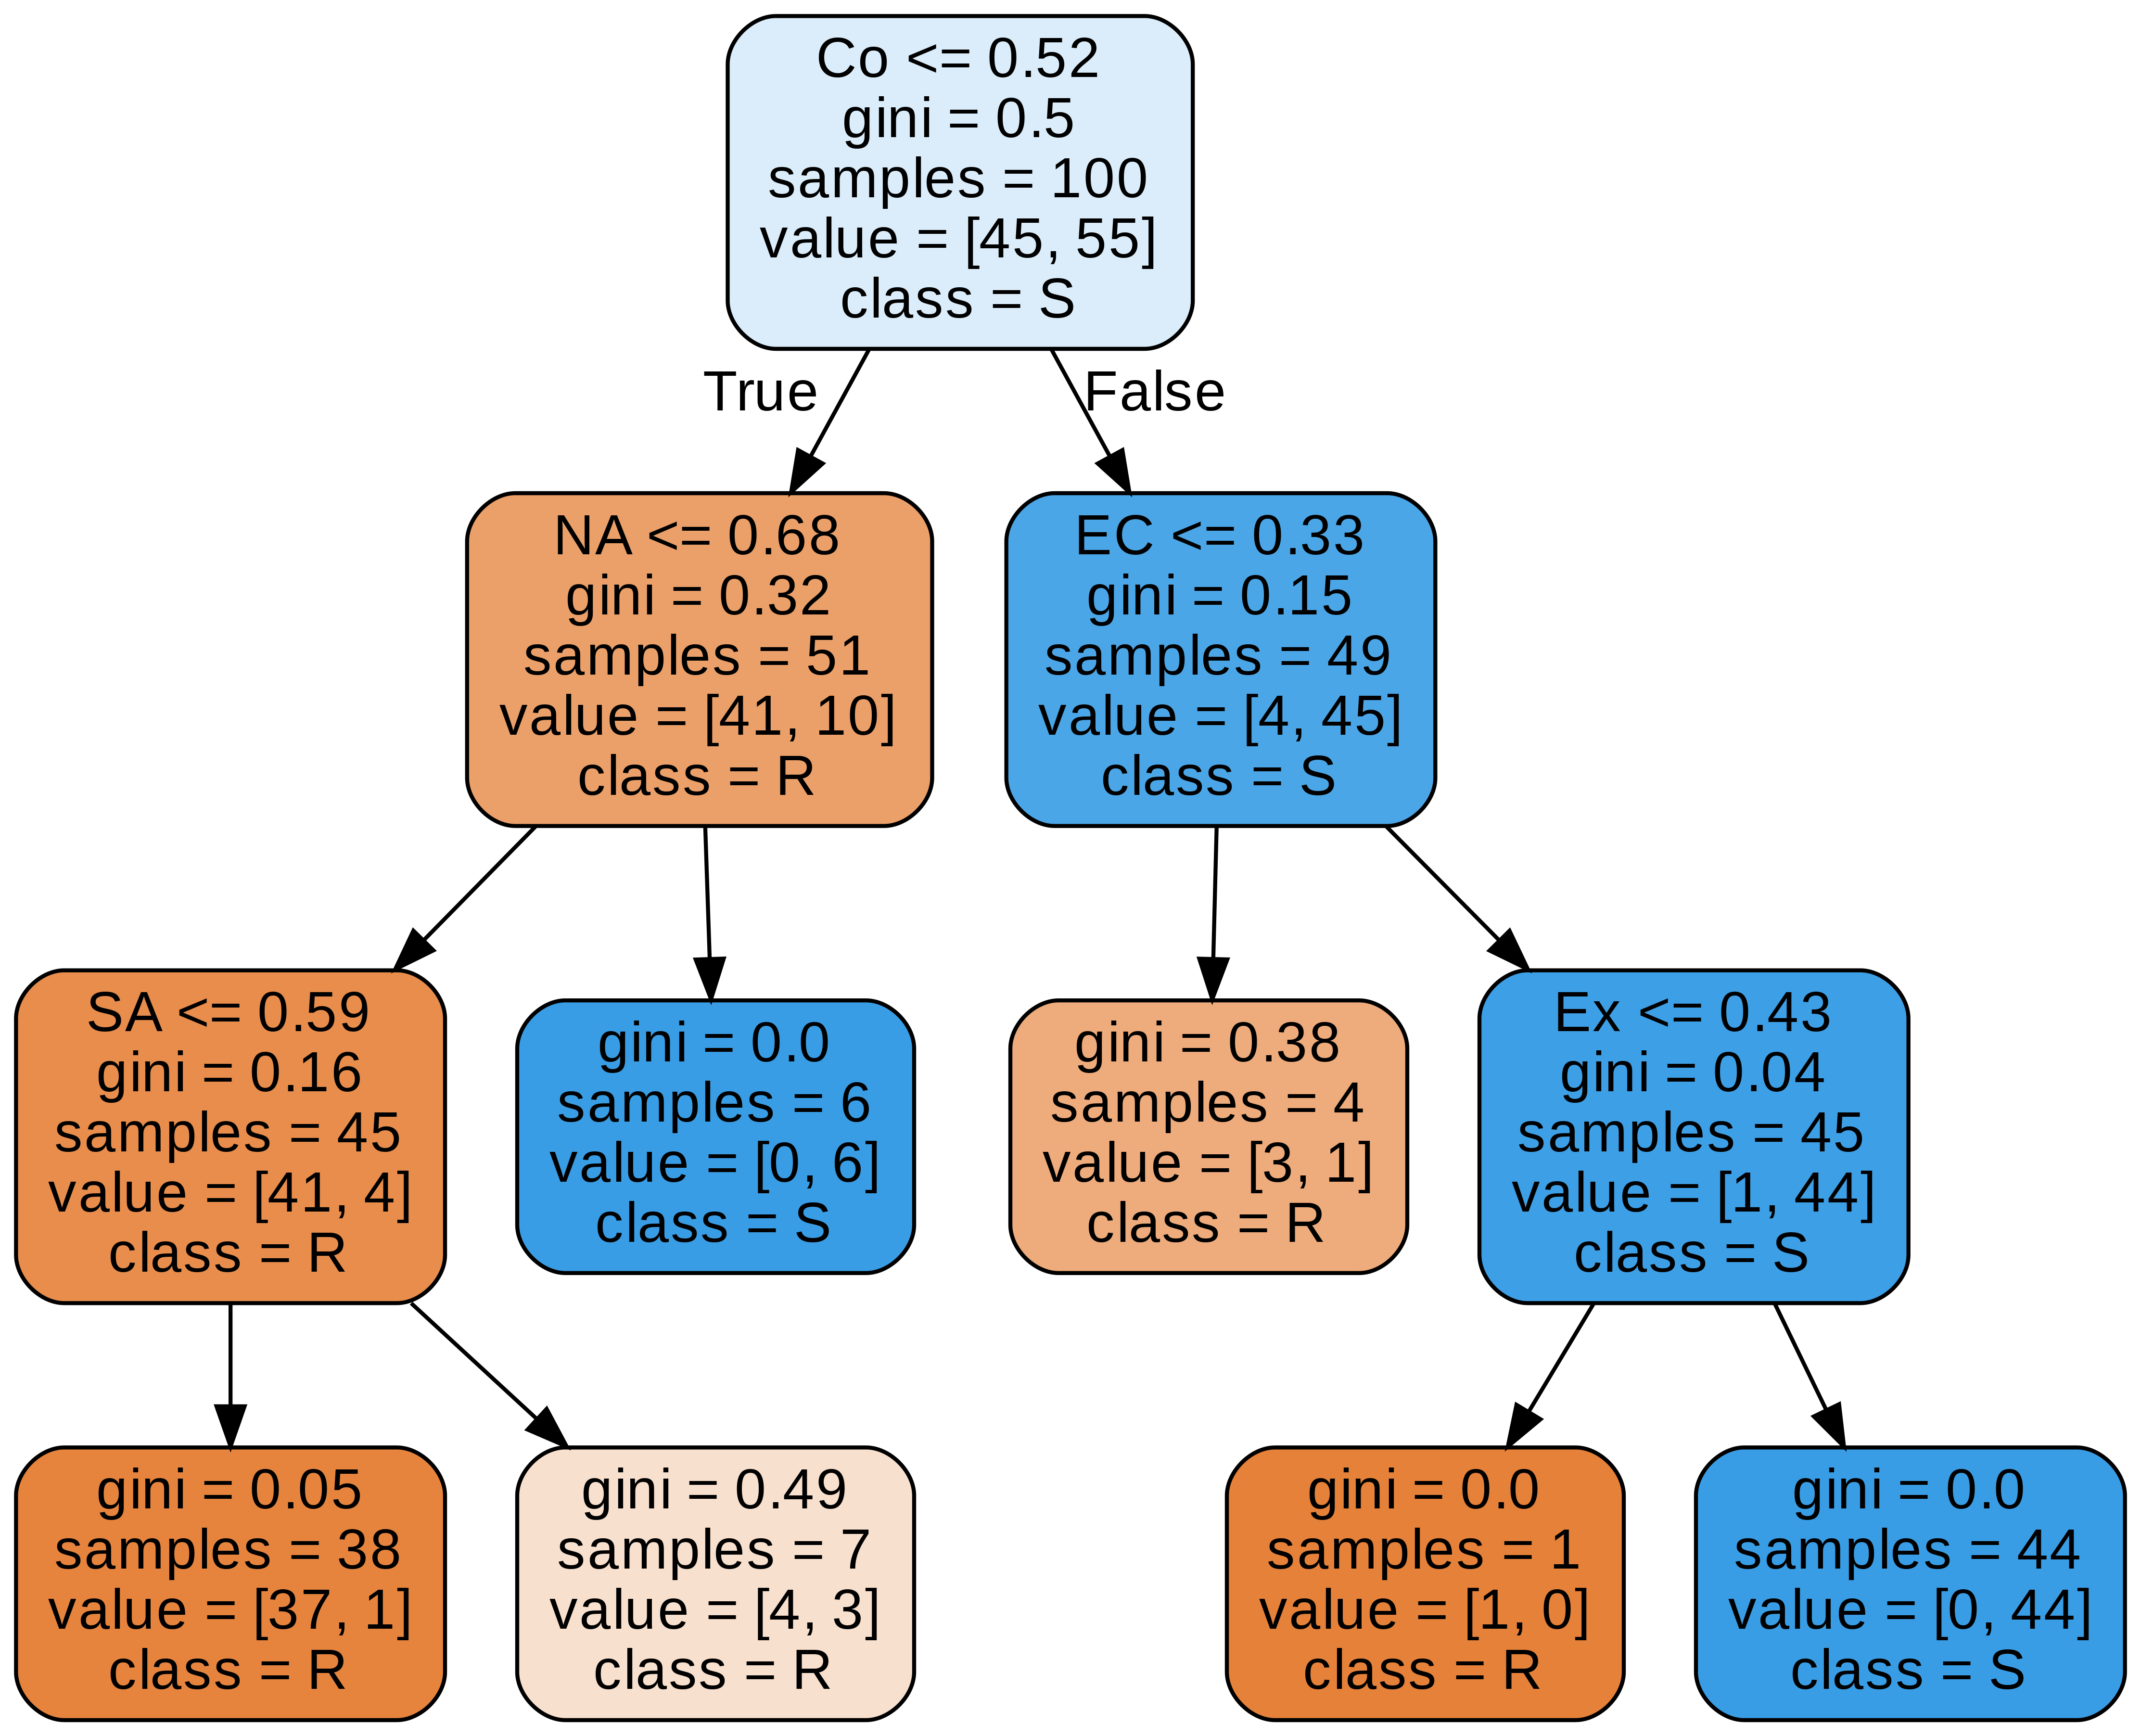

In [ ]:
from sklearn.tree import export_graphviz

feature_names = ['Co', 'En', 'Ex', 'EC', 'S', 'SR', 'NF', 'Fr', 'P', 'ET', 'SA', 'Ca', 'NS', 'Fo', 'A', 'NA']
# Export as dot file
export_graphviz(final_regr, out_file='tree-mit-cat.dot', 
                feature_names = feature_names,
                class_names = ['R', 'S'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree-mit-cat.dot', '-o', 'tree-mit-cat.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree-mit-cat.png')

# Whole Dataset

In [ ]:
mit_data = mit_df[['answers', 'RecommendHiringCat']].values

In [ ]:
all_words = []
documents = []

from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('english')))
stop_words.append('inaudible')
stop_words.append('du')

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J", "V","R"]

for p in mit_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
print(mit_data)

[[" im pretty good. ok  uhm  so have you looked at my resume or should i  alright  so i guess ah  i am course 6-7 here at m.i.t  ah which is computational biology  so its a mix of computers  science and biology and actually thats where my interest lie in applying like algorithmic kinda software engineering too datasets dealing with genomics and biology.  uhm some of that activities that you do out side of school  include camp kesem which is a summer camp that we run for completely free for kids whose parents have cancer  as well as ah amphibious achievement  which is ah a high school tutoring program for inner city kids in boston   so ah  my interest kinda laid both in a little bit of the health care  i imagined i was going be a doctor growing up  and then it came down to the tee and im like  well i can do engineering and still apply and do the same things and help a lot more people. ok  uhm  one of the things we have to do for camp kesem is orgin or fundraise all the money to ah  to  

In [ ]:
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:1000]
word_features[0], word_features[-1], len(word_features)

('pretty', 'significant', 1000)

In [ ]:
save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Creating features for each review
mitfeatures = [(find_features(rev), i) for (rev, i) in mit_data]

mitfeatures = np.array(mitfeatures)

print(mitfeatures.shape)

(138, 2)


In [ ]:
print(mitfeatures[101])

[{'pretty': True, 'good': True, 'looked': False, 'resume': False, 'alright': False, 'computational': False, 'actually': True, 'thats': False, 'applying': False, 'algorithmic': False, 'dealing': False, 'uhm': False, 'side': False, 'include': False, 'run': False, 'completely': False, 'free': False, 'well': True, 'ah': False, 'amphibious': False, 'high': False, 'tutoring': False, 'inner': False, 'boston': False, 'laid': False, 'little': True, 'imagined': False, 'going': False, 'growing': False, 'came': False, 'tee': False, 'still': False, 'apply': False, 'help': False, 'ok': True, 'camp': False, 'kesem': False, 'orgin': False, 'individually': False, 'spearhead': False, 'called': False, 'say': False, 'fraternity': False, 'go': False, 'solicit': False, 'form': False, 'raise': False, 'sell': False, 'use': True, 'obviously': False, 'donate': False, 'entire': True, 'send': False, 'make': True, 'sure': True, 'goes': False, 'according': False, 'ahh': False, 'easiest': False, 'last': False, 'work

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

training_set = mitfeatures[100:]
test_set = mitfeatures[:100]

In [ ]:

for train_index, test_index in kf.split(mitfeatures):
  print("##### RUN #####")
  print("")
  # print("TRAIN:", train_index, "TEST:", test_index)
  training_set = mitfeatures[train_index]
  testing_set = mitfeatures[test_index]

  classifier = nltk.NaiveBayesClassifier.train(training_set)
  print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
  classifier.show_most_informative_features(15)


  MNB_clf = SklearnClassifier(MultinomialNB())
  MNB_clf.train(training_set)
  print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)

  BNB_clf = SklearnClassifier(BernoulliNB())
  BNB_clf.train(training_set)
  print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)

  LogReg_clf = SklearnClassifier(LogisticRegression())
  LogReg_clf.train(training_set)
  print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)

  SVC_clf = SklearnClassifier(SVC())
  SVC_clf.train(training_set)
  print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)

  print("")

##### RUN #####

Classifier accuracy percent: 57.14285714285714
Most Informative Features
                recently = True                1 : 0      =      6.2 : 1.0
                   robot = True                0 : 1      =      5.4 : 1.0
                  unique = True                1 : 0      =      5.1 : 1.0
                  double = True                1 : 0      =      5.1 : 1.0
                speaking = True                0 : 1      =      4.7 : 1.0
              consulting = True                1 : 0      =      4.6 : 1.0
              fraternity = True                1 : 0      =      4.6 : 1.0
                      ta = True                0 : 1      =      4.5 : 1.0
                 opposed = True                0 : 1      =      4.5 : 1.0
             participate = True                1 : 0      =      4.0 : 1.0
              passionate = True                1 : 0      =      4.0 : 1.0
                  social = True                1 : 0      =      4.0 : 1.0
          

In [ ]:
nb_list = []
mnb_list = []
bnb_list = []
lr_list = []
svc_list = []
for train_index, test_index in kf.split(mitfeatures):
  print("##### RUN #####")
  print("")
  # print("TRAIN:", train_index, "TEST:", test_index)
  training_set = mitfeatures[train_index]
  testing_set = mitfeatures[test_index]

  classifier = nltk.NaiveBayesClassifier.train(training_set)
  #print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
  nb_list.append((nltk.classify.accuracy(classifier, testing_set))*100)
  classifier.show_most_informative_features(15)


  MNB_clf = SklearnClassifier(MultinomialNB())
  MNB_clf.train(training_set)
  #print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)
  mnb_list.append((nltk.classify.accuracy(MNB_clf, testing_set))*100)

  BNB_clf = SklearnClassifier(BernoulliNB())
  BNB_clf.train(training_set)
  #print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)
  bnb_list.append((nltk.classify.accuracy(BNB_clf, testing_set))*100)

  LogReg_clf = SklearnClassifier(LogisticRegression())
  LogReg_clf.train(training_set)
  #print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)
  lr_list.append((nltk.classify.accuracy(LogReg_clf, testing_set))*100)

  SVC_clf = SklearnClassifier(SVC())
  SVC_clf.train(training_set)
  #print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)
  svc_list.append((nltk.classify.accuracy(SVC_clf, testing_set))*100)

  print("")

print("NB Classifier accuracy percent:", np.mean(nb_list), np.std(nb_list))
print("MNB Classifier accuracy percent:", np.mean(mnb_list), np.std(mnb_list))
print("BNB Classifier accuracy percent:", np.mean(bnb_list), np.std(bnb_list))
print("LR Classifier accuracy percent:", np.mean(lr_list), np.std(lr_list))
print("SVC Classifier accuracy percent:", np.mean(svc_list), np.std(svc_list))

##### RUN #####

Most Informative Features
               professor = True                0 : 1      =      5.8 : 1.0
                recently = True                1 : 0      =      5.8 : 1.0
                speaking = True                0 : 1      =      5.1 : 1.0
                 opposed = True                0 : 1      =      4.9 : 1.0
                  living = True                0 : 1      =      4.9 : 1.0
                  finish = True                0 : 1      =      4.5 : 1.0
              consulting = True                1 : 0      =      4.2 : 1.0
                  unique = True                1 : 0      =      4.2 : 1.0
                  showed = True                0 : 1      =      4.0 : 1.0
                  slowly = True                0 : 1      =      4.0 : 1.0
                 produce = True                0 : 1      =      4.0 : 1.0
                  weekly = True                0 : 1      =      4.0 : 1.0
                  rowing = True                0 : 1     

# Part 1
**bold text**

In [ ]:
mit_df = pd.read_csv('split_parts.csv')

mit_df['RecommendHiringCat'] = np.where( mit_df['RecommendHiring'] > 0.5, 1, 0)
mit_df

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,answers,part1,part2,part3,part4,part5,RecommendHiringCat
0,p1,AGGR,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826,Im pretty good. ok uhm so have you looked a...,Im pretty good. ok uhm so have you looked a...,vement which is ah a high school tutoring pro...,led the Camp Kesem I say you did auction wher...,ject which is algorithm or software architectu...,e where in cases this situation presents itsel...,1
1,p3,AGGR,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691,Good. You? Yeah sorry I was- think I was la...,Good. You? Yeah sorry I was- think I was la...,ust make this a team?” It was about 15 or 20 o...,meetings to figure out what type of robot we w...,really tricky and . . . I think the first time...,ot of practice . . . . . . and just doing more...,0
2,p4,AGGR,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246,Pretty good. Uhh so I'm a junior uhh studyin...,Pretty good. Uhh so I'm a junior uhh studyin...,son ended up uhh sh- wasn't showing up very mu...,n students. Umm as it turns out umm the challe...,were available there. Umm you know there were ...,sically uhh do work there as opposed to try to...,0
3,p5,AGGR,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970,Myself um I'm a junior majoring in computer...,Myself um I'm a junior majoring in computer...,an our annual New York City Trip. And um so...,I was working on a team was in my Elemental S...,to solve the technical problem. One of my wea...,essentially. That what I would do to accompl...,1
4,p6,AGGR,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672,I’m doing good. How are you?Thank you. Well ...,I’m doing good. How are you?Thank you. Well ...,ech industry I had the privilege of talking t...,It required programming construction and educ...,One thing I learned about internships is to no...,reading books um. I definitely have been netw...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,pp83,AGGR,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047,Um pretty good pretty good. Getting busy wi...,Um pretty good pretty good. Getting busy wi...,roscience. So I took that fell in love with n...,t in terms of classroom management and getting...,.. Um so uh I participated in that in that...,... And um in a similar field but sort of ...,1
134,pp84,AGGR,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313,Good thank you how are you? Alright well ...,Good thank you how are you? Alright well ...,at least be...if I want to see something done ...,d two co-presidents and one of them was a pret...,working via email it was good. And then toda...,vest money to obtain partnerships and sponsor...,1
135,pp85,AGGR,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612,Okay well I'm a junior here at MIT. Umm I'm...,Okay well I'm a junior here at MIT. Umm I'm...,ple and uh and 

In [ ]:
mit_data = mit_df[['part1', 'RecommendHiringCat']].values

In [ ]:
all_words = []
documents = []

from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('english')))
stop_words.append('inaudible')
stop_words.append('du')

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J", "V","R"]

for p in mit_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
print(mit_data)

[[' im pretty good. ok  uhm  so have you looked at my resume or should i  alright  so i guess ah  i am course 6-7 here at m.i.t  ah which is computational biology  so its a mix of computers  science and biology and actually thats where my interest lie in applying like algorithmic kinda software engineering too datasets dealing with genomics and biology.  uhm some of that activities that you do out side of school  include camp kesem which is a summer camp that we run for completely free for kids whose parents have cancer  as well as ah amphibious achie'
  1]
 [' good. you? yeah  sorry  i was- think i was late. i totally  like  messed up. i thought we were at the media lab. but . . . ahh  hmm. so  uhh  i would- would say that the job i’m interviewing for  let’s stay down here. so  yeay   i’m chase  and i guess  um  i don’t know. i really enjoy computers and outdoors  that’s -that’s generally what i give people. um  so in both of these  um  in computers mainly  uhh  at mit i think some of

In [ ]:
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:1000]
word_features[0], word_features[-1], len(word_features)

('pretty', 'pure', 1000)

In [ ]:
save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Creating features for each review
mitfeatures = [(find_features(rev), i) for (rev, i) in mit_data]

mitfeatures = np.array(mitfeatures)

print(mitfeatures.shape)

(138, 2)


In [ ]:
print(mitfeatures[101])

[{'pretty': False, 'good': False, 'looked': False, 'resume': False, 'alright': False, 'computational': False, 'actually': False, 'thats': False, 'applying': False, 'algorithmic': False, 'dealing': False, 'uhm': False, 'side': False, 'include': False, 'run': False, 'completely': False, 'free': False, 'well': False, 'ah': False, 'amphibious': False, 'sorry': False, 'think': True, 'late': False, 'totally': False, 'messed': False, 'thought': False, 'ahh': False, 'say': False, 'im': False, 'interviewing': False, 'stay': False, 'yeay': False, 'um': False, 'know': True, 'really': False, 'enjoy': False, 'generally': False, 'give': False, 'mainly': False, 'uhh': False, 'favorite': False, 'interesting': True, 'getting': False, 'deep': False, 'interested': True, 'came': False, 'webdevelopment': False, 'umm': True, 'otherwise': False, 'working': False, 'random': False, 'going': False, 'sp': False, 'hanging': False, 'yeah': True, 'building': False, 'cool': False, 'main': False, 'ultimate': False, '

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

training_set = mitfeatures[100:]
test_set = mitfeatures[:100]

In [ ]:
nb_list = []
mnb_list = []
bnb_list = []
lr_list = []
svc_list = []
for train_index, test_index in kf.split(mitfeatures):
  print("##### RUN #####")
  print("")
  # print("TRAIN:", train_index, "TEST:", test_index)
  training_set = mitfeatures[train_index]
  testing_set = mitfeatures[test_index]

  classifier = nltk.NaiveBayesClassifier.train(training_set)
  #print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
  nb_list.append((nltk.classify.accuracy(classifier, testing_set))*100)
  classifier.show_most_informative_features(15)


  MNB_clf = SklearnClassifier(MultinomialNB())
  MNB_clf.train(training_set)
  #print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)
  mnb_list.append((nltk.classify.accuracy(MNB_clf, testing_set))*100)

  BNB_clf = SklearnClassifier(BernoulliNB())
  BNB_clf.train(training_set)
  #print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)
  bnb_list.append((nltk.classify.accuracy(BNB_clf, testing_set))*100)

  LogReg_clf = SklearnClassifier(LogisticRegression())
  LogReg_clf.train(training_set)
  #print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)
  lr_list.append((nltk.classify.accuracy(LogReg_clf, testing_set))*100)

  SVC_clf = SklearnClassifier(SVC())
  SVC_clf.train(training_set)
  #print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)
  svc_list.append((nltk.classify.accuracy(SVC_clf, testing_set))*100)

  print("")

print("NB Classifier accuracy percent:", np.mean(nb_list), np.std(nb_list))
print("MNB Classifier accuracy percent:", np.mean(mnb_list), np.std(mnb_list))
print("BNB Classifier accuracy percent:", np.mean(bnb_list), np.std(bnb_list))
print("LR Classifier accuracy percent:", np.mean(lr_list), np.std(lr_list))
print("SVC Classifier accuracy percent:", np.mean(svc_list), np.std(svc_list))

##### RUN #####

Most Informative Features
                thinking = True                1 : 0      =      4.3 : 1.0
              consulting = True                1 : 0      =      4.3 : 1.0
                  double = True                1 : 0      =      3.8 : 1.0
                   minor = True                1 : 0      =      3.8 : 1.0
                     far = True                1 : 0      =      3.8 : 1.0
                    took = True                1 : 0      =      3.8 : 1.0
                     try = True                1 : 0      =      3.2 : 1.0
                    even = True                1 : 0      =      3.2 : 1.0
                recently = True                1 : 0      =      3.2 : 1.0
                   front = True                1 : 0      =      3.2 : 1.0
                    make = True                1 : 0      =      3.2 : 1.0
                   moved = True                0 : 1      =      3.0 : 1.0
                  senior = True                0 : 1     

# Part 2
**bold text**

In [ ]:
mit_df = pd.read_csv('split_parts.csv')

mit_df['RecommendHiringCat'] = np.where( mit_df['RecommendHiring'] > 0.5, 1, 0)
mit_df

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,answers,part1,part2,part3,part4,part5,RecommendHiringCat
0,p1,AGGR,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826,Im pretty good. ok uhm so have you looked a...,Im pretty good. ok uhm so have you looked a...,vement which is ah a high school tutoring pro...,led the Camp Kesem I say you did auction wher...,ject which is algorithm or software architectu...,e where in cases this situation presents itsel...,1
1,p3,AGGR,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691,Good. You? Yeah sorry I was- think I was la...,Good. You? Yeah sorry I was- think I was la...,ust make this a team?” It was about 15 or 20 o...,meetings to figure out what type of robot we w...,really tricky and . . . I think the first time...,ot of practice . . . . . . and just doing more...,0
2,p4,AGGR,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246,Pretty good. Uhh so I'm a junior uhh studyin...,Pretty good. Uhh so I'm a junior uhh studyin...,son ended up uhh sh- wasn't showing up very mu...,n students. Umm as it turns out umm the challe...,were available there. Umm you know there were ...,sically uhh do work there as opposed to try to...,0
3,p5,AGGR,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970,Myself um I'm a junior majoring in computer...,Myself um I'm a junior majoring in computer...,an our annual New York City Trip. And um so...,I was working on a team was in my Elemental S...,to solve the technical problem. One of my wea...,essentially. That what I would do to accompl...,1
4,p6,AGGR,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672,I’m doing good. How are you?Thank you. Well ...,I’m doing good. How are you?Thank you. Well ...,ech industry I had the privilege of talking t...,It required programming construction and educ...,One thing I learned about internships is to no...,reading books um. I definitely have been netw...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,pp83,AGGR,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047,Um pretty good pretty good. Getting busy wi...,Um pretty good pretty good. Getting busy wi...,roscience. So I took that fell in love with n...,t in terms of classroom management and getting...,.. Um so uh I participated in that in that...,... And um in a similar field but sort of ...,1
134,pp84,AGGR,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313,Good thank you how are you? Alright well ...,Good thank you how are you? Alright well ...,at least be...if I want to see something done ...,d two co-presidents and one of them was a pret...,working via email it was good. And then toda...,vest money to obtain partnerships and sponsor...,1
135,pp85,AGGR,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612,Okay well I'm a junior here at MIT. Umm I'm...,Okay well I'm a junior here at MIT. Umm I'm...,ple and uh and 

In [ ]:
mit_data = mit_df[['part2', 'RecommendHiringCat']].values

In [ ]:
all_words = []
documents = []

from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('english')))
stop_words.append('inaudible')
stop_words.append('du')

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J", "V","R"]

for p in mit_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
print(mit_data)

[['vement  which is ah a high school tutoring program for inner city kids in boston   so ah  my interest kinda laid both in a little bit of the health care  i imagined i was going be a doctor growing up  and then it came down to the tee and im like  well i can do engineering and still apply and do the same things and help a lot more people. ok  uhm  one of the things we have to do for camp kesem is orgin or fundraise all the money to ah  to  run the camp which is over $50 000.00.  ah so one of the things that i individually spearhead every year is cal'
  1]
 ['ust make this a team?” it was about 15 or 20 of us. umm  so i became captain and what that entailed was getting people to practices every day or maybe three times a week  depending on  like  how people’s schedules were. but it was definitely tricky because  i mean  we had to get  you know  at least 15 people out on the field to be able to actually play a game  because you need 7 on each side. umm  so  uhh  getting all this organi

In [ ]:
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:1000]
word_features[0], word_features[-1], len(word_features)

('ah', 'weight', 1000)

In [ ]:
save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Creating features for each review
mitfeatures = [(find_features(rev), i) for (rev, i) in mit_data]

mitfeatures = np.array(mitfeatures)

print(mitfeatures.shape)

(138, 2)


In [ ]:
print(mitfeatures[101])

[{'ah': False, 'high': False, 'tutoring': False, 'inner': False, 'boston': False, 'laid': False, 'little': False, 'imagined': False, 'going': False, 'growing': False, 'came': False, 'tee': False, 'well': False, 'still': False, 'apply': False, 'help': False, 'ok': False, 'uhm': False, 'camp': False, 'kesem': False, 'orgin': False, 'run': False, 'individually': False, 'spearhead': False, 'ust': False, 'make': False, 'umm': True, 'became': False, 'entailed': False, 'getting': False, 'maybe': False, 'depending': False, 'definitely': False, 'tricky': False, 'mean': False, 'know': True, 'least': False, 'able': True, 'actually': False, 'play': False, 'need': False, 'uhh': False, 'organized': False, 'everyday': False, 'pretty': False, 'hard': False, 'passionate': False, 'enough': False, 'needed': False, 'went': False, 'tournament': False, 'got': False, 'th': False, 'junior': False, 'senior': False, 'great': False, 'playing': False, 'yeah': False, 'lets': False, 'go': False, 'robotics': False, 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

training_set = mitfeatures[100:]
test_set = mitfeatures[:100]

In [ ]:
nb_list = []
mnb_list = []
bnb_list = []
lr_list = []
svc_list = []
for train_index, test_index in kf.split(mitfeatures):
  print("##### RUN #####")
  print("")
  # print("TRAIN:", train_index, "TEST:", test_index)
  training_set = mitfeatures[train_index]
  testing_set = mitfeatures[test_index]

  classifier = nltk.NaiveBayesClassifier.train(training_set)
  #print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
  nb_list.append((nltk.classify.accuracy(classifier, testing_set))*100)
  classifier.show_most_informative_features(15)


  MNB_clf = SklearnClassifier(MultinomialNB())
  MNB_clf.train(training_set)
  #print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)
  mnb_list.append((nltk.classify.accuracy(MNB_clf, testing_set))*100)

  BNB_clf = SklearnClassifier(BernoulliNB())
  BNB_clf.train(training_set)
  #print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)
  bnb_list.append((nltk.classify.accuracy(BNB_clf, testing_set))*100)

  LogReg_clf = SklearnClassifier(LogisticRegression())
  LogReg_clf.train(training_set)
  #print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)
  lr_list.append((nltk.classify.accuracy(LogReg_clf, testing_set))*100)

  SVC_clf = SklearnClassifier(SVC())
  SVC_clf.train(training_set)
  #print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)
  svc_list.append((nltk.classify.accuracy(SVC_clf, testing_set))*100)

  print("")

print("NB Classifier accuracy percent:", np.mean(nb_list), np.std(nb_list))
print("MNB Classifier accuracy percent:", np.mean(mnb_list), np.std(mnb_list))
print("BNB Classifier accuracy percent:", np.mean(bnb_list), np.std(bnb_list))
print("LR Classifier accuracy percent:", np.mean(lr_list), np.std(lr_list))
print("SVC Classifier accuracy percent:", np.mean(svc_list), np.std(svc_list))

##### RUN #####

Most Informative Features
                     bit = True                1 : 0      =      6.2 : 1.0
                 control = True                0 : 1      =      4.9 : 1.0
                    give = True                1 : 0      =      4.2 : 1.0
                    camp = True                0 : 1      =      4.0 : 1.0
                      na = True                0 : 1      =      4.0 : 1.0
                    find = True                1 : 0      =      3.8 : 1.0
                    club = True                1 : 0      =      3.8 : 1.0
                    back = True                1 : 0      =      3.8 : 1.0
                  helped = True                0 : 1      =      3.5 : 1.0
                  little = True                1 : 0      =      3.4 : 1.0
                    came = True                1 : 0      =      3.4 : 1.0
                planning = True                1 : 0      =      3.2 : 1.0
                     use = True                1 : 0     

# Part 3
**bold text**

In [ ]:
mit_df = pd.read_csv('split_parts.csv')

mit_df['RecommendHiringCat'] = np.where( mit_df['RecommendHiring'] > 0.5, 1, 0)
mit_df

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,answers,part1,part2,part3,part4,part5,RecommendHiringCat
0,p1,AGGR,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826,Im pretty good. ok uhm so have you looked a...,Im pretty good. ok uhm so have you looked a...,vement which is ah a high school tutoring pro...,led the Camp Kesem I say you did auction wher...,ject which is algorithm or software architectu...,e where in cases this situation presents itsel...,1
1,p3,AGGR,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691,Good. You? Yeah sorry I was- think I was la...,Good. You? Yeah sorry I was- think I was la...,ust make this a team?” It was about 15 or 20 o...,meetings to figure out what type of robot we w...,really tricky and . . . I think the first time...,ot of practice . . . . . . and just doing more...,0
2,p4,AGGR,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246,Pretty good. Uhh so I'm a junior uhh studyin...,Pretty good. Uhh so I'm a junior uhh studyin...,son ended up uhh sh- wasn't showing up very mu...,n students. Umm as it turns out umm the challe...,were available there. Umm you know there were ...,sically uhh do work there as opposed to try to...,0
3,p5,AGGR,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970,Myself um I'm a junior majoring in computer...,Myself um I'm a junior majoring in computer...,an our annual New York City Trip. And um so...,I was working on a team was in my Elemental S...,to solve the technical problem. One of my wea...,essentially. That what I would do to accompl...,1
4,p6,AGGR,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672,I’m doing good. How are you?Thank you. Well ...,I’m doing good. How are you?Thank you. Well ...,ech industry I had the privilege of talking t...,It required programming construction and educ...,One thing I learned about internships is to no...,reading books um. I definitely have been netw...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,pp83,AGGR,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047,Um pretty good pretty good. Getting busy wi...,Um pretty good pretty good. Getting busy wi...,roscience. So I took that fell in love with n...,t in terms of classroom management and getting...,.. Um so uh I participated in that in that...,... And um in a similar field but sort of ...,1
134,pp84,AGGR,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313,Good thank you how are you? Alright well ...,Good thank you how are you? Alright well ...,at least be...if I want to see something done ...,d two co-presidents and one of them was a pret...,working via email it was good. And then toda...,vest money to obtain partnerships and sponsor...,1
135,pp85,AGGR,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612,Okay well I'm a junior here at MIT. Umm I'm...,Okay well I'm a junior here at MIT. Umm I'm...,ple and uh and 

In [ ]:
mit_data = mit_df[['part3', 'RecommendHiringCat']].values

In [ ]:
all_words = []
documents = []

from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('english')))
stop_words.append('inaudible')
stop_words.append('du')

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J", "V","R"]

for p in mit_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
print(mit_data)

[['led the camp kesem i say you did auction  where actually my fraternity and i go out and solicit uhm  donations in the form of gift cards  ah to raise money for a date auction where we actually sell dates  and then we use this money obviously we donate it to camp kesem. i spearhead the entire event and i kinda orginize everyone into committees and groups  and i send the people out and make sure everything goes according to plan.    ahh  i guess the easiest team project i just i just had  was  last semester  uhm i worked on this six double o five pro'
  1]
 ['meetings to figure out what type of robot we would be building and stuff. umm  and i guess  uhh  what i wanted to do was  umm  basically go ahead with everything we’d already done. uhh  and just push forward with that and just finish off basically. and what my team members wanted to do was actually redo everything and start from the very bottom. umm  so what we ended up doing  i actually took their side  umm  and it worked out ve

In [ ]:
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:1000]
word_features[0], word_features[-1], len(word_features)

('led', 'smarter', 1000)

In [ ]:
save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Creating features for each review
mitfeatures = [(find_features(rev), i) for (rev, i) in mit_data]

mitfeatures = np.array(mitfeatures)

print(mitfeatures.shape)

(138, 2)


In [ ]:
print(mitfeatures[101])

[{'led': False, 'say': False, 'actually': False, 'fraternity': False, 'go': False, 'solicit': False, 'uhm': False, 'form': False, 'ah': False, 'raise': False, 'sell': False, 'use': True, 'obviously': False, 'donate': False, 'entire': False, 'send': False, 'make': True, 'sure': False, 'goes': False, 'according': False, 'ahh': False, 'easiest': False, 'last': False, 'worked': False, 'double': False, 'building': False, 'umm': True, 'wanted': False, 'basically': False, 'ahead': False, 'wed': False, 'already': False, 'done': False, 'uhh': True, 'forward': False, 'finish': False, 'team': True, 'redo': False, 'ended': False, 'took': False, 'well': False, 'quite': False, 'tricky': False, 'involved': False, 'really': False, 'cool': False, 'figuring': False, 'exactly': False, 'see': False, 'cheated': False, 'tile': False, 'everywhere': False, 'able': True, 'color': False, 'coloring': False, 'stops': False, 'look': False, 'light': False, 'white': False, 'bottom': False, 'wall': False, 'existed': 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

training_set = mitfeatures[100:]
test_set = mitfeatures[:100]

In [ ]:
nb_list = []
mnb_list = []
bnb_list = []
lr_list = []
svc_list = []
for train_index, test_index in kf.split(mitfeatures):
  print("##### RUN #####")
  print("")
  # print("TRAIN:", train_index, "TEST:", test_index)
  training_set = mitfeatures[train_index]
  testing_set = mitfeatures[test_index]

  classifier = nltk.NaiveBayesClassifier.train(training_set)
  #print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
  nb_list.append((nltk.classify.accuracy(classifier, testing_set))*100)
  classifier.show_most_informative_features(15)


  MNB_clf = SklearnClassifier(MultinomialNB())
  MNB_clf.train(training_set)
  #print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)
  mnb_list.append((nltk.classify.accuracy(MNB_clf, testing_set))*100)

  BNB_clf = SklearnClassifier(BernoulliNB())
  BNB_clf.train(training_set)
  #print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)
  bnb_list.append((nltk.classify.accuracy(BNB_clf, testing_set))*100)

  LogReg_clf = SklearnClassifier(LogisticRegression())
  LogReg_clf.train(training_set)
  #print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)
  lr_list.append((nltk.classify.accuracy(LogReg_clf, testing_set))*100)

  SVC_clf = SklearnClassifier(SVC())
  SVC_clf.train(training_set)
  #print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)
  svc_list.append((nltk.classify.accuracy(SVC_clf, testing_set))*100)

  print("")

print("NB Classifier accuracy percent:", np.mean(nb_list), np.std(nb_list))
print("MNB Classifier accuracy percent:", np.mean(mnb_list), np.std(mnb_list))
print("BNB Classifier accuracy percent:", np.mean(bnb_list), np.std(bnb_list))
print("LR Classifier accuracy percent:", np.mean(lr_list), np.std(lr_list))
print("SVC Classifier accuracy percent:", np.mean(svc_list), np.std(svc_list))

##### RUN #####

Most Informative Features
                     lab = True                0 : 1      =      6.8 : 1.0
                    need = True                1 : 0      =      5.9 : 1.0
                   maybe = True                1 : 0      =      4.0 : 1.0
                  helped = True                0 : 1      =      3.9 : 1.0
             communicate = True                0 : 1      =      3.9 : 1.0
                 exactly = True                0 : 1      =      3.9 : 1.0
               technical = True                0 : 1      =      3.2 : 1.0
                  taking = True                0 : 1      =      3.2 : 1.0
                    move = True                0 : 1      =      3.2 : 1.0
              particular = True                0 : 1      =      3.2 : 1.0
                    knew = True                1 : 0      =      3.2 : 1.0
                deadline = True                1 : 0      =      2.8 : 1.0
                    felt = True                1 : 0     

# Part 4
**bold text**

In [ ]:
mit_df = pd.read_csv('split_parts.csv')

mit_df['RecommendHiringCat'] = np.where( mit_df['RecommendHiring'] > 0.5, 1, 0)
mit_df

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,answers,part1,part2,part3,part4,part5,RecommendHiringCat
0,p1,AGGR,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826,Im pretty good. ok uhm so have you looked a...,Im pretty good. ok uhm so have you looked a...,vement which is ah a high school tutoring pro...,led the Camp Kesem I say you did auction wher...,ject which is algorithm or software architectu...,e where in cases this situation presents itsel...,1
1,p3,AGGR,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691,Good. You? Yeah sorry I was- think I was la...,Good. You? Yeah sorry I was- think I was la...,ust make this a team?” It was about 15 or 20 o...,meetings to figure out what type of robot we w...,really tricky and . . . I think the first time...,ot of practice . . . . . . and just doing more...,0
2,p4,AGGR,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246,Pretty good. Uhh so I'm a junior uhh studyin...,Pretty good. Uhh so I'm a junior uhh studyin...,son ended up uhh sh- wasn't showing up very mu...,n students. Umm as it turns out umm the challe...,were available there. Umm you know there were ...,sically uhh do work there as opposed to try to...,0
3,p5,AGGR,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970,Myself um I'm a junior majoring in computer...,Myself um I'm a junior majoring in computer...,an our annual New York City Trip. And um so...,I was working on a team was in my Elemental S...,to solve the technical problem. One of my wea...,essentially. That what I would do to accompl...,1
4,p6,AGGR,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672,I’m doing good. How are you?Thank you. Well ...,I’m doing good. How are you?Thank you. Well ...,ech industry I had the privilege of talking t...,It required programming construction and educ...,One thing I learned about internships is to no...,reading books um. I definitely have been netw...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,pp83,AGGR,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047,Um pretty good pretty good. Getting busy wi...,Um pretty good pretty good. Getting busy wi...,roscience. So I took that fell in love with n...,t in terms of classroom management and getting...,.. Um so uh I participated in that in that...,... And um in a similar field but sort of ...,1
134,pp84,AGGR,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313,Good thank you how are you? Alright well ...,Good thank you how are you? Alright well ...,at least be...if I want to see something done ...,d two co-presidents and one of them was a pret...,working via email it was good. And then toda...,vest money to obtain partnerships and sponsor...,1
135,pp85,AGGR,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612,Okay well I'm a junior here at MIT. Umm I'm...,Okay well I'm a junior here at MIT. Umm I'm...,ple and uh and 

In [ ]:
mit_data = mit_df[['part4', 'RecommendHiringCat']].values

In [ ]:
all_words = []
documents = []

from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('english')))
stop_words.append('inaudible')
stop_words.append('du')

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J", "V","R"]

for p in mit_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
print(mit_data)

[["ject which is algorithm or software architecture. and we were put in a group of 3 people  and it was standard you know we signed the contract everyone is supposed to work equally  but it ended up being by the end of it  that someone didn't like put there fair share of work in...ah essentially we talked to him we didn't really get it out  we actually had to go to some of the t.a's we got a little bit ah  and that kinda like pushed him forward  so i mean i guess what i am showing is like  im not affraid to go to the right method or like authority lik"
  1]
 ['really tricky and . . . i think the first time they’d actually had  umm  some- something like this instead of just looking for balls and doing path planning. umm  actually local- relocalization in the world. yeah. ok  uhh  hmm. one of my weaknesses? umm  i would go with  umm  . . . umm . . .yeah i should’ve had a better answer for this question . . .umm  i guess . . . i don’t know if i can plan to overcome it. [laughing] i don’t 

In [ ]:
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:1000]
word_features[0], word_features[-1], len(word_features)

('put', 'mentorlike', 1000)

In [ ]:
save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Creating features for each review
mitfeatures = [(find_features(rev), i) for (rev, i) in mit_data]

mitfeatures = np.array(mitfeatures)

print(mitfeatures.shape)

(138, 2)


In [ ]:
print(mitfeatures[101])

[{'put': False, 'standard': False, 'know': True, 'signed': False, 'supposed': False, 'equally': False, 'ended': False, 'fair': False, 'inah': False, 'essentially': False, 'talked': False, 'really': False, 'get': False, 'actually': False, 'go': False, 'tas': False, 'got': False, 'little': True, 'ah': False, 'pushed': False, 'forward': False, 'mean': False, 'showing': False, 'right': False, 'tricky': False, 'think': False, 'first': False, 'umm': True, 'instead': True, 'looking': False, 'planning': False, 'local': False, 'ok': False, 'uhh': False, 'weaknesses': False, 'better': False, 'answer': False, 'overcome': False, 'laughing': False, 'id': False, 'say': False, 'wish': False, 'working': True, 'enjoy': False, 'general': False, 'biggest': False, 'focuses': False, 'great': False, 'able': True, 'basically': False, 'inspire': False, 'stuff': False, 'good': True, 'found': False, 'im': False, 'best': False, 'various': False, 'social': False, 'ive': False, 'need': False, 'sometimes': False, '

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

training_set = mitfeatures[100:]
test_set = mitfeatures[:100]

In [ ]:
nb_list = []
mnb_list = []
bnb_list = []
lr_list = []
svc_list = []
for train_index, test_index in kf.split(mitfeatures):
  print("##### RUN #####")
  print("")
  # print("TRAIN:", train_index, "TEST:", test_index)
  training_set = mitfeatures[train_index]
  testing_set = mitfeatures[test_index]

  classifier = nltk.NaiveBayesClassifier.train(training_set)
  #print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
  nb_list.append((nltk.classify.accuracy(classifier, testing_set))*100)
  classifier.show_most_informative_features(15)


  MNB_clf = SklearnClassifier(MultinomialNB())
  MNB_clf.train(training_set)
  #print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)
  mnb_list.append((nltk.classify.accuracy(MNB_clf, testing_set))*100)

  BNB_clf = SklearnClassifier(BernoulliNB())
  BNB_clf.train(training_set)
  #print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)
  bnb_list.append((nltk.classify.accuracy(BNB_clf, testing_set))*100)

  LogReg_clf = SklearnClassifier(LogisticRegression())
  LogReg_clf.train(training_set)
  #print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)
  lr_list.append((nltk.classify.accuracy(LogReg_clf, testing_set))*100)

  SVC_clf = SklearnClassifier(SVC())
  SVC_clf.train(training_set)
  #print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)
  svc_list.append((nltk.classify.accuracy(SVC_clf, testing_set))*100)

  print("")

print("NB Classifier accuracy percent:", np.mean(nb_list), np.std(nb_list))
print("MNB Classifier accuracy percent:", np.mean(mnb_list), np.std(mnb_list))
print("BNB Classifier accuracy percent:", np.mean(bnb_list), np.std(bnb_list))
print("LR Classifier accuracy percent:", np.mean(lr_list), np.std(lr_list))
print("SVC Classifier accuracy percent:", np.mean(svc_list), np.std(svc_list))

##### RUN #####

Most Informative Features
                    want = True                1 : 0      =      6.2 : 1.0
               important = True                1 : 0      =      4.7 : 1.0
                 improve = True                0 : 1      =      4.4 : 1.0
                  couple = True                0 : 1      =      4.4 : 1.0
                   front = True                0 : 1      =      4.4 : 1.0
                  making = True                1 : 0      =      4.2 : 1.0
                  public = True                0 : 1      =      3.6 : 1.0
                  taking = True                0 : 1      =      3.6 : 1.0
                   quiet = True                0 : 1      =      3.6 : 1.0
                     ask = True                0 : 1      =      3.6 : 1.0
                    show = True                0 : 1      =      3.6 : 1.0
               challenge = True                0 : 1      =      3.6 : 1.0
                   ideas = True                1 : 0     

# Part 5

In [ ]:
mit_df = pd.read_csv('split_parts.csv')

mit_df['RecommendHiringCat'] = np.where( mit_df['RecommendHiring'] > 0.5, 1, 0)
mit_df

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,answers,part1,part2,part3,part4,part5,RecommendHiringCat
0,p1,AGGR,0.604841,0.554311,0.626235,0.659192,0.598523,0.717068,0.276517,0.718451,0.484012,0.550738,0.765332,0.680198,0.575487,0.530824,0.567044,0.651826,0.419451,0.727863,0.532826,Im pretty good. ok uhm so have you looked a...,Im pretty good. ok uhm so have you looked a...,vement which is ah a high school tutoring pro...,led the Camp Kesem I say you did auction wher...,ject which is algorithm or software architectu...,e where in cases this situation presents itsel...,1
1,p3,AGGR,0.333196,0.359621,0.513049,0.683243,0.749805,0.592960,0.812195,0.787075,0.393918,0.914130,0.432972,0.792833,0.304886,0.215940,0.631946,0.535371,0.649223,0.588421,0.510691,Good. You? Yeah sorry I was- think I was la...,Good. You? Yeah sorry I was- think I was la...,ust make this a team?” It was about 15 or 20 o...,meetings to figure out what type of robot we w...,really tricky and . . . I think the first time...,ot of practice . . . . . . and just doing more...,0
2,p4,AGGR,0.357701,0.387692,0.334195,0.644096,0.386246,0.149650,0.551463,0.660348,0.348582,0.584319,0.560095,0.500492,0.519343,0.427888,0.649030,0.446397,0.446636,0.469956,0.347246,Pretty good. Uhh so I'm a junior uhh studyin...,Pretty good. Uhh so I'm a junior uhh studyin...,son ended up uhh sh- wasn't showing up very mu...,n students. Umm as it turns out umm the challe...,were available there. Umm you know there were ...,sically uhh do work there as opposed to try to...,0
3,p5,AGGR,0.654204,0.688896,0.780443,0.775645,0.507153,0.951056,0.350710,0.746498,0.916850,0.665787,0.793615,0.572545,0.766390,0.811457,0.782404,0.839817,0.652126,0.766199,0.716970,Myself um I'm a junior majoring in computer...,Myself um I'm a junior majoring in computer...,an our annual New York City Trip. And um so...,I was working on a team was in my Elemental S...,to solve the technical problem. One of my wea...,essentially. That what I would do to accompl...,1
4,p6,AGGR,0.546104,0.474850,0.460474,0.491441,0.491202,0.283562,0.409696,0.403917,0.514508,0.329178,0.510806,0.469378,0.557435,0.702896,0.747381,0.562806,0.283868,0.682164,0.398672,I’m doing good. How are you?Thank you. Well ...,I’m doing good. How are you?Thank you. Well ...,ech industry I had the privilege of talking t...,It required programming construction and educ...,One thing I learned about internships is to no...,reading books um. I definitely have been netw...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,pp83,AGGR,0.835238,0.756880,0.982337,0.885172,0.805423,0.711886,0.902880,0.622579,0.702942,0.928411,0.753500,0.835756,0.571867,0.581856,0.582537,0.745811,0.958367,0.819237,0.809047,Um pretty good pretty good. Getting busy wi...,Um pretty good pretty good. Getting busy wi...,roscience. So I took that fell in love with n...,t in terms of classroom management and getting...,.. Um so uh I participated in that in that...,... And um in a similar field but sort of ...,1
134,pp84,AGGR,0.731904,0.818683,0.662797,0.726350,0.669966,0.631989,0.913778,0.623175,0.745779,0.922648,0.802211,0.793847,0.575082,0.444765,0.719312,0.708184,0.782121,0.650441,0.731313,Good thank you how are you? Alright well ...,Good thank you how are you? Alright well ...,at least be...if I want to see something done ...,d two co-presidents and one of them was a pret...,working via email it was good. And then toda...,vest money to obtain partnerships and sponsor...,1
135,pp85,AGGR,0.706045,0.745304,0.787068,0.927802,0.745260,0.834080,0.594292,0.444331,0.550784,0.759624,0.713705,0.701988,0.582849,0.399050,0.433092,0.931286,0.852547,0.557471,0.659612,Okay well I'm a junior here at MIT. Umm I'm...,Okay well I'm a junior here at MIT. Umm I'm...,ple and uh and 

In [ ]:
mit_data = mit_df[['part5', 'RecommendHiringCat']].values

In [ ]:
all_words = []
documents = []

from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('english')))
stop_words.append('inaudible')
stop_words.append('du')

#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J", "V","R"]

for p in mit_data:
    
    # create a list of tuples where the first element of each tuple is a review
    # the second element is the label
    
    # remove punctuations

    p[0] = p[0].lower()

    cleaned = re.sub(r'[^(a-zA-Z)\s]','', p[0])
    
    # tokenize 
    tokenized = word_tokenize(cleaned)
    
    # remove stopwords 
    stopped = [w for w in tokenized if not w in stop_words]
    
    # parts of speech tagging for each word 
    part_of_speech = nltk.pos_tag(stopped)
    
    # make a list of  all adjectives identified by the allowed word types list above
    for w in part_of_speech:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

In [ ]:
print(mit_data)

[["e where in cases this situation presents itself.    uhmmm.  i would say for this job  ah im a little technically underprepared.  ah i've yet  i have only taken the introductory software classes so far and as well as introductory bio classes  but i think just from sheer interest and sheer effort i will be able to kinda overcome these obstacles.  ah  im very interested  in the subject of computation biology  and i think that i will be able to contribute a lot to this field  uhm i've had a good amount of experience and i think i will be a solid intern."
  1]
 ['ot of practice . . . . . . and just doing more  uhh  basically again  like i’ve been doing a lot of teamwork in general.  i do really enjoy it. so i think it just comes with practice and being very conscious about how other people do stuff very well and inspire me  umm  so hopefully i can inspire others. umm  [laughs] uhh  i guess because  umm  i- i would probably say the one word comes down to passion. umm  i- whatever i’m doin

In [ ]:
BOW = nltk.FreqDist(all_words)
word_features = list(BOW.keys())[:1000]
word_features[0], word_features[-1], len(word_features)

('presents', 'survived', 1000)

In [ ]:
save_word_features = open("word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()

In [ ]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

# Creating features for each review
mitfeatures = [(find_features(rev), i) for (rev, i) in mit_data]

mitfeatures = np.array(mitfeatures)

print(mitfeatures.shape)

(138, 2)


In [ ]:
print(mitfeatures[101])

[{'presents': False, 'uhmmm': False, 'say': False, 'ah': False, 'im': False, 'little': False, 'technically': False, 'underprepared': False, 'ive': False, 'yet': False, 'taken': False, 'classes': False, 'far': False, 'well': True, 'introductory': False, 'think': True, 'sheer': False, 'able': False, 'kinda': False, 'interested': False, 'subject': False, 'uhm': False, 'good': False, 'solid': False, 'ot': False, 'uhh': True, 'basically': False, 'general': False, 'really': False, 'enjoy': False, 'comes': False, 'conscious': False, 'stuff': False, 'inspire': False, 'umm': False, 'hopefully': False, 'laughs': False, 'probably': False, 'make': False, 'sure': False, 'always': False, 'thinking': False, 'working': False, 'generally': False, 'pretty': False, 'small': False, 'try': False, 'narrow': False, 'cant': False, 'take': True, 'many': False, 'solve': False, 'reading': False, 'know': True, 'helpful': False, 'overflows': False, 'frequently': False, 'jumping': False, 'explaining': False, 'liste

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

training_set = mitfeatures[100:]
test_set = mitfeatures[:100]

In [ ]:
nb_list = []
mnb_list = []
bnb_list = []
lr_list = []
svc_list = []
for train_index, test_index in kf.split(mitfeatures):
  print("##### RUN #####")
  print("")
  # print("TRAIN:", train_index, "TEST:", test_index)
  training_set = mitfeatures[train_index]
  testing_set = mitfeatures[test_index]

  classifier = nltk.NaiveBayesClassifier.train(training_set)
  #print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
  nb_list.append((nltk.classify.accuracy(classifier, testing_set))*100)
  classifier.show_most_informative_features(15)


  MNB_clf = SklearnClassifier(MultinomialNB())
  MNB_clf.train(training_set)
  #print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)
  mnb_list.append((nltk.classify.accuracy(MNB_clf, testing_set))*100)

  BNB_clf = SklearnClassifier(BernoulliNB())
  BNB_clf.train(training_set)
  #print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)
  bnb_list.append((nltk.classify.accuracy(BNB_clf, testing_set))*100)

  LogReg_clf = SklearnClassifier(LogisticRegression())
  LogReg_clf.train(training_set)
  #print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)
  lr_list.append((nltk.classify.accuracy(LogReg_clf, testing_set))*100)

  SVC_clf = SklearnClassifier(SVC())
  SVC_clf.train(training_set)
  #print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)
  svc_list.append((nltk.classify.accuracy(SVC_clf, testing_set))*100)

  print("")

print("NB Classifier accuracy percent:", np.mean(nb_list), np.std(nb_list))
print("MNB Classifier accuracy percent:", np.mean(mnb_list), np.std(mnb_list))
print("BNB Classifier accuracy percent:", np.mean(bnb_list), np.std(bnb_list))
print("LR Classifier accuracy percent:", np.mean(lr_list), np.std(lr_list))
print("SVC Classifier accuracy percent:", np.mean(svc_list), np.std(svc_list))

##### RUN #####

Most Informative Features
               candidate = True                1 : 0      =      3.9 : 1.0
                semester = True                0 : 1      =      3.9 : 1.0
               hopefully = True                0 : 1      =      3.9 : 1.0
                speaking = True                0 : 1      =      3.9 : 1.0
            demonstrated = True                0 : 1      =      3.9 : 1.0
                somebody = True                0 : 1      =      3.9 : 1.0
              internship = True                0 : 1      =      3.9 : 1.0
                     use = True                0 : 1      =      3.3 : 1.0
                  pretty = True                0 : 1      =      3.1 : 1.0
                    self = True                0 : 1      =      3.0 : 1.0
                 balance = True                0 : 1      =      3.0 : 1.0
                  larger = True                0 : 1      =      3.0 : 1.0
               confident = True                0 : 1     